## Load Data

In [22]:
import pandas as pd
import numpy as np

import glob
from pyntcloud import PyntCloud

In [23]:
def load_ply(file_name):
    cloud = PyntCloud.from_file(file_name)
    return cloud.points.values

In [24]:
def load_obj(file_name):
    vertices = []
    with open(file_name) as f:
        for line in f:
            if line[:2] == 'v ':
                index1 = line.find(' ') + 1
                index2 = line.find(' ', index1 + 1)
                index3 = line.find(' ', index2 + 1)

                vertex = (float(line[index1:index2]), float(line[index2:index3]), float(line[index3:-1]))
                vertex = [round(vertex[0], 2), round(vertex[1], 2), round(vertex[2], 2)]
                vertices.append(np.array(vertex))
                
    return np.array(vertices)

In [25]:
def load_off(file_name):
    vertices = []
    with open(file_name) as f:
        for i, line in enumerate(f):
            vals = line.split(' ')
            if i > 2 and len(vals) == 3:
                vertex = [float(vals[0]), float(vals[1]), float(vals[2])]
                vertices.append(np.array(vertex))

    return np.random.permutation(np.array(vertices))[:2048]

## Create Dataset

In [26]:
from torch.utils.data import Dataset, DataLoader

In [27]:
class PointCloudDataset(Dataset):
    """Point cloud dataset."""

    def __init__(self, number=-1, directory='./data/04379243'):
        
        file_names = glob.glob('%s/*.ply' % directory)

        if number > 0 and len(file_names) > number:
            file_names = file_names[:number]
        
        point_clouds = []
        for file_name in file_names:

            points = load_ply(file_name)
            point_clouds.append(points)

        self.point_clouds = np.array(point_clouds, dtype='float64')
        self.point_clouds = np.transpose(self.point_clouds, (0, 2, 1))
        
    def __len__(self):
        return len(self.point_clouds)

    def __getitem__(self, idx):

        return self.point_clouds[idx]

In [28]:
point_cloud_dataset = PointCloudDataset(8480)
dataloader = DataLoader(point_cloud_dataset, batch_size=32, shuffle=True)

## Auto encoder

In [29]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

In [30]:
class Encoder(nn.Module):

    def __init__(self):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, 128, 1)
        self.conv4 = nn.Conv1d(128, 256, 1)
        self.conv5 = nn.Conv1d(256, 32, 1)
        self.maxPool1d = nn.MaxPool1d(2048)
        
        self.relu = nn.ReLU()
        self.bn1  = nn.BatchNorm1d(64) 
        self.bn2  = nn.BatchNorm1d(128) 
        self.bn3  = nn.BatchNorm1d(128)
        self.bn4  = nn.BatchNorm1d(256) 
        self.bn5  = nn.BatchNorm1d(32) 

    def forward(self, x):

        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = torch.max(x, 2, keepdim=True)[0]#self.maxPool1d(x)
        return x

Encoder()

Encoder(
  (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
  (conv4): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (conv5): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
  (maxPool1d): MaxPool1d(kernel_size=2048, stride=2048, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [31]:
class Decoder(nn.Module):

    def __init__(self):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(32, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2048*3)

        self.relu = nn.ReLU()
        self.bn1  = nn.BatchNorm1d(256) 
        self.bn2  = nn.BatchNorm1d(256) 
        
    def forward(self, x):

        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = x.view(-1, 3, 2048)
        
        return x
    
Decoder()

Decoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=6144, bias=True)
  (relu): ReLU()
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [32]:
class AutoEncoder(nn.Module):
    
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

## Training

In [33]:
from lib.chamfer import ChamferLoss
from lib.callbacks import EarlyStopping

model = AutoEncoder()

criterion = ChamferLoss()

early_stopping = EarlyStopping(patience=20)

num_epochs = 500
learning_rate = 1e-2

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=5.0, momentum=0.9)

if torch.cuda.is_available():
    model = model.cuda()

for epoch in range(num_epochs):
    
    if epoch == 0:
        early_stopping.on_train_begin()

    running_loss = 0.0
    
    for data in dataloader:

        data = data.float()
        
        if torch.cuda.is_available():
            data = data.cuda()
            
        train_output = model(data)
        loss = criterion(train_output, data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.data  
    
    if early_stopping.on_epoch_end(epoch + 1, running_loss):
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, running_loss))
        print('Terminated Training for Early Stopping at Epoch %04i' % (epoch + 1))
        break
        
    if (epoch + 1) % 5 == 0:
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, running_loss))

RuntimeError: CUDA error: out of memory

#### save

In [ ]:
torch.save(model.encoder.state_dict(), './models/encoder.pt')
torch.save(model.decoder.state_dict(), './models/decoder.pt')

### get input values for validation

In [34]:
train_input  = next(iter(dataloader)).float()

if torch.cuda.is_available():
    train_output = model(train_input.cuda())
    train_output = train_output.cpu()
else:
    train_output = model(train_input)

In [35]:
v_encoder = Encoder()
v_decoder = Decoder()

v_encoder.load_state_dict(torch.load('./models/encoder.pt'))
v_decoder.load_state_dict(torch.load('./models/decoder.pt'))

## Generator

In [16]:
class Generator(nn.Module):
    
    def __init__(self, encoder, decoder):
        super(Generator, self).__init__()

        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        x = self.encoder(x)
        x[:,1,0] *= 10.0
        x = self.decoder(x)
        
        return x

In [17]:
generator = Generator(v_encoder, v_decoder)
generator_output = generator(train_input)

## Validation

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

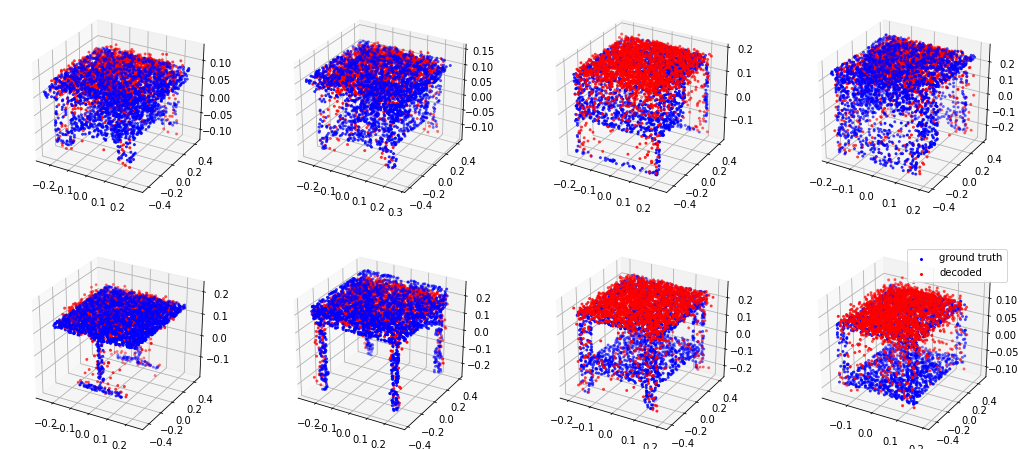

In [19]:
fig = plt.figure(figsize=(18, 8))

for i in range(8):
    
    row, columns, num = 2, 4, i + 1
    ax = fig.add_subplot(row, columns, num, projection='3d')

    data = train_input[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='b', label='ground truth')

    data = train_output[i].detach().numpy()
    ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='r', label='decoded')

#     data = generator_output[i].detach().numpy()
#     ax.scatter(data[0], data[1], data[2], zdir='z', s=4, c='g', label='decoded & modified')

ax.legend()
plt.show()

In [20]:
for i in range(8):
    d1 = train_input[i].detach().numpy()
    d2 = train_output[i].detach().numpy()
    print(np.sum(abs(d1 - d2)))

1044.828
1044.4277
1134.4434
1222.3715
959.6615
1126.0765
1193.0822
1047.6091


In [21]:
for i in range(8):
    d1 = train_input[i]
    d2 = train_output[i]
    print(criterion(d1.reshape(1, 3, 2048), d2.reshape(1, 3, 2048)).data)

tensor(2.5671)
tensor(2.2621)
tensor(3.5538)
tensor(3.1029)
tensor(1.2572)
tensor(1.9966)
tensor(2.2299)
tensor(2.5085)


## Write to File

In [ ]:
def write(points, file_name, directory='./output/'):
    
    if points.shape[0] < points.shape[1] and points.shape[0] == 3:
        points = points.T
    
    with open(directory + file_name, 'w') as f:
        
        f.write(str(points.shape[0]) + '\n')

        for pt in points:
            f.write('%.8f %.8f %.8f\n' % tuple(pt))
    
write(next(iter(dataloader))[2].detach().numpy(), 'point_cloud.txt')

## TODOs

* Manimulate latent vector or try something else to generate more nice tables
* Reduce the number of point clouds or connect each points reasonably

## Misc

In [ ]:
input = torch.randn(10, 2048, 3)
print(input.shape)
m = nn.Conv1d(2048, 256, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(256, 128, 1)
output = m(output)
m = nn.Conv1d(128, 64, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(64, 32, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(3)
output = m(output)
print(output.shape)

In [ ]:
input = torch.randn(10, 3, 2048)
print(input.shape)
m = nn.Conv1d(3, 64, 1)
output = m(input)
print(output.shape)
m = nn.Conv1d(64, 128, 1)
output = m(output)
m = nn.Conv1d(128, 256, 1)
output = m(output)
print(output.shape)
m = nn.Conv1d(256, 512, 1)
output = m(output)
print(output.shape)
m = nn.MaxPool1d(2048) # output = torch.max(output, 2, keepdim=True)[0]
output = m(output)
print(output.shape)

In [ ]:
class TmpLoss(nn.Module):

    # https://github.com/345ishaan/DenseLidarNet/blob/master/code/chamfer_loss.py
    def __init__(self):
        super(TmpLoss, self).__init__()
        self.use_cuda = torch.cuda.is_available()        

    def forward(self,preds,gts):
        P = self.batch_pairwise_dist(gts, preds)
        mins, _ = torch.min(P, 1)
        loss_1 = torch.sum(mins)
        mins, _ = torch.min(P, 2)
        loss_2 = torch.sum(mins)
        return loss_1 + loss_2

    def batch_pairwise_dist(self,x,y):
        x = x.transpose(2, 1)
        y = y.transpose(2, 1)
        _, num_points_x, _ = x.size()
        _, num_points_y, _ = y.size()
        xx = torch.bmm(x, x.transpose(2,1))
        yy = torch.bmm(y, y.transpose(2,1))
        zz = torch.bmm(x, y.transpose(2,1))
        if self.use_cuda:
            dtype = torch.cuda.LongTensor
        else:
            dtype = torch.LongTensor
        diag_ind_x = torch.arange(0, num_points_x).type(dtype)
        diag_ind_y = torch.arange(0, num_points_y).type(dtype)
        rx = xx[:, diag_ind_x, diag_ind_x].unsqueeze(1).expand_as(zz.transpose(2,1))
        ry = yy[:, diag_ind_y, diag_ind_y].unsqueeze(1).expand_as(zz)
        P = (rx.transpose(2,1) + ry - 2*zz)
        return P

In [ ]:
input = Variable(torch.ones(2, 3, 12))
output = Variable(torch.zeros(2, 3, 12))
ls = TmpLoss()
ls.forward(input, output)

In [ ]:
xx = torch.bmm(input, input.transpose(2,1))
xx.shape

In [ ]:
input.transpose(2,1)

In [ ]:
input